In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-03
n_kernels=256

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

cm_threshold = 10

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x_para = np.hstack((t, hh, bb))
    x = total_coords.reshape((n_cases, 2, 55, 1))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, x_para, y, t, cm

In [10]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and $C_m$: ", input_time_cm.shape)
    return input_time_cm

In [11]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [12]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>cm_threshold:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [13]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [14]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [15]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((baseline_coord_high, baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [16]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [17]:
# Generating x, y and cm (for denormalizing)
x, x_para, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and $C_m$:  (80000, 2)
Dimension - heights of Gurney flaps:  (80000, 1)
Dimension - inclination(beta):  (80000, 1)
Dimension - airfoil coordinates:  (80000, 100)
Dimension - coord with flaps:  (80000, 10)
Dimension - total coordinates:  (80000, 110)
Dimension - x:  (80000, 2, 55, 1)
Dimension - y:  (80000, 1)


In [18]:
def dataset_split(x, x_para, y, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, x_para_all, x_para_test, y_all, y_test = train_test_split(x,x_para,
                                                                                 y, test_size=test_rate,
                                                                                 random_state=kwargs.get('random_state'))
        x_train, x_val, x_para_train, x_para_val, y_train, y_val = train_test_split(x_all, x_para_all,
                                                                                    y_all, test_size=val_rate/(1-test_rate),
                                                                                    random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, x_para_train, x_para_val, x_para_test, y_train, y_val, y_test
    else:
        x_train, x_test, x_para_train, x_para_test, y_train, y_test = train_test_split(x, x_para, y,
                                                                                       test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test

In [19]:
x_train, x_val, x_test, x_para_train, x_para_val, x_para_test, y_train, y_val, y_test = dataset_split(x, x_para, y, test_rate, val_rate=val_rate,
                                                                                                      validation=True, random_state=26)

In [20]:
def make_aeroCNN1_model(n_kernels, num_layer:int = 5): # This function can only generate model with at least 3 hidden layers
    input_1 = tf.keras.Input(shape=(2,55,1))
    input_2 = tf.keras.Input(shape=(3))

    x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1, padding='same',
                                     activation='relu', name='convLayer',
                                     kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(input_1)
    x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)

    x_flat = tf.keras.layers.Flatten()(x_pool)
    x_concat = tf.keras.layers.Concatenate()([x_flat, input_2])
    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(x_concat)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model([input_1, input_2], output_data)
    
    return model

In [21]:
model = make_aeroCNN1_model(n_kernels, num_layer=n_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 256)   1280        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 256)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 6912)         0           ['max_pooling2d[0][0]']          
                                                                                              

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [23]:
model_directory = "D:\\TrainedModels\\20221218"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [24]:
ckpt_name = model_directory + "20221218unsteadyPrediction_AeroCNN1_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-09,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-10, min_lr=1e-06, verbose=1)

In [25]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [26]:
start = datetime.datetime.now()
history = model.fit([x_train, x_para_train], y_train, batch_size=batch_size,
                    validation_data=([x_val, x_para_val], y_val),
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8994 - rmse: 0.0662
Epoch 1: val_loss improved from inf to 2.72996, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 6s 14ms/step - loss: 2.8854 - rmse: 0.0631 - val_loss: 2.7300 - val_rmse: 0.0044 - lr: 1.0000e-04
Epoch 2/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6092 - rmse: 0.0055
Epoch 2: val_loss improved from 2.72996 to 2.47350, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 2.6001 - rmse: 0.0054 - val_loss: 2.4735 - val_rmse: 0.0015 - lr: 1.0000e-04
Epoch 3/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3730 - rmse: 0.0054
Epoch 3: val_loss improved from 2.47350 to 2.25937, saving model to D:\TrainedModels\2022121820

50/55 [==========================>...] - ETA: 0s - loss: 0.7123 - rmse: 0.0069
Epoch 21: val_loss improved from 0.72911 to 0.69185, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.7106 - rmse: 0.0066 - val_loss: 0.6919 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 22/10000
55/55 [==============================] - ETA: 0s - loss: 0.6748 - rmse: 0.0046
Epoch 22: val_loss improved from 0.69185 to 0.65756, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.6748 - rmse: 0.0046 - val_loss: 0.6576 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 23/10000
55/55 [==============================] - ETA: 0s - loss: 0.6418 - rmse: 0.0028
Epoch 23: val_loss improved from 0.65756 to 0.62598, saving model to D:\TrainedModels\202212182022121

55/55 [==============================] - ETA: 0s - loss: 0.3312 - rmse: 0.0051
Epoch 41: val_loss improved from 0.33563 to 0.32660, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.3312 - rmse: 0.0051 - val_loss: 0.3266 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 42/10000
55/55 [==============================] - ETA: 0s - loss: 0.3224 - rmse: 0.0045
Epoch 42: val_loss improved from 0.32660 to 0.31801, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.3224 - rmse: 0.0045 - val_loss: 0.3180 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 43/10000
54/55 [============================>.] - ETA: 0s - loss: 0.3141 - rmse: 0.0068
Epoch 43: val_loss improved from 0.31801 to 0.30984, saving model to D:\TrainedModels\202212182022121

54/55 [============================>.] - ETA: 0s - loss: 0.2091 - rmse: 0.0052
Epoch 61: val_loss improved from 0.21114 to 0.20688, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.2091 - rmse: 0.0051 - val_loss: 0.2069 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 62/10000
51/55 [==========================>...] - ETA: 0s - loss: 0.2050 - rmse: 0.0053
Epoch 62: val_loss improved from 0.20688 to 0.20274, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.2049 - rmse: 0.0051 - val_loss: 0.2027 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 63/10000
54/55 [============================>.] - ETA: 0s - loss: 0.2008 - rmse: 0.0052
Epoch 63: val_loss improved from 0.20274 to 0.19870, saving model to D:\TrainedModels\202212182022121

53/55 [===========================>..] - ETA: 0s - loss: 0.1418 - rmse: 0.0067
Epoch 81: val_loss improved from 0.14302 to 0.14032, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 0.1417 - rmse: 0.0066 - val_loss: 0.1403 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 82/10000
53/55 [===========================>..] - ETA: 0s - loss: 0.1391 - rmse: 0.0045
Epoch 82: val_loss improved from 0.14032 to 0.13768, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.1390 - rmse: 0.0051 - val_loss: 0.1377 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 83/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.1365 - rmse: 0.0048
Epoch 83: val_loss improved from 0.13768 to 0.13508, saving model to D:\TrainedModels\202212182022121

49/55 [=========================>....] - ETA: 0s - loss: 0.0962 - rmse: 0.0048
Epoch 101: val_loss improved from 0.09704 to 0.09511, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0961 - rmse: 0.0046 - val_loss: 0.0951 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 102/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0943 - rmse: 0.0052
Epoch 102: val_loss improved from 0.09511 to 0.09321, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 0.0942 - rmse: 0.0050 - val_loss: 0.0932 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 103/10000
55/55 [==============================] - ETA: 0s - loss: 0.0923 - rmse: 0.0051
Epoch 103: val_loss improved from 0.09321 to 0.09133, saving model to D:\TrainedModels\2022121820

Epoch 121/10000
55/55 [==============================] - ETA: 0s - loss: 0.0628 - rmse: 0.0051
Epoch 121: val_loss improved from 0.06352 to 0.06210, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0628 - rmse: 0.0051 - val_loss: 0.0621 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 122/10000
51/55 [==========================>...] - ETA: 0s - loss: 0.0615 - rmse: 0.0053
Epoch 122: val_loss improved from 0.06210 to 0.06071, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0614 - rmse: 0.0051 - val_loss: 0.0607 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 123/10000
55/55 [==============================] - ETA: 0s - loss: 0.0601 - rmse: 0.0045
Epoch 123: val_loss improved from 0.06071 to 0.05934, saving model to D:\TrainedM

Epoch 141/10000
52/55 [===========================>..] - ETA: 0s - loss: 0.0388 - rmse: 0.0058
Epoch 141: val_loss improved from 0.03923 to 0.03823, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0388 - rmse: 0.0056 - val_loss: 0.0382 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 142/10000
54/55 [============================>.] - ETA: 0s - loss: 0.0378 - rmse: 0.0052
Epoch 142: val_loss improved from 0.03823 to 0.03724, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0378 - rmse: 0.0051 - val_loss: 0.0372 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 143/10000
54/55 [============================>.] - ETA: 0s - loss: 0.0368 - rmse: 0.0067
Epoch 143: val_loss improved from 0.03724 to 0.03627, saving model to D:\TrainedM

Epoch 161/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0222 - rmse: 0.0054
Epoch 161: val_loss improved from 0.02242 to 0.02175, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 0.0221 - rmse: 0.0051 - val_loss: 0.0218 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 162/10000
55/55 [==============================] - ETA: 0s - loss: 0.0214 - rmse: 0.0045
Epoch 162: val_loss improved from 0.02175 to 0.02110, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0214 - rmse: 0.0045 - val_loss: 0.0211 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 163/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0208 - rmse: 0.0053
Epoch 163: val_loss improved from 0.02110 to 0.02045, saving model to D:\TrainedM

Epoch 181/10000
54/55 [============================>.] - ETA: 0s - loss: 0.0114 - rmse: 0.0067
Epoch 181: val_loss improved from 0.01157 to 0.01115, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0114 - rmse: 0.0067 - val_loss: 0.0112 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 182/10000
49/55 [=========================>....] - ETA: 0s - loss: 0.0110 - rmse: 0.0053
Epoch 182: val_loss improved from 0.01115 to 0.01075, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0110 - rmse: 0.0051 - val_loss: 0.0108 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 183/10000
49/55 [=========================>....] - ETA: 0s - loss: 0.0106 - rmse: 0.0054
Epoch 183: val_loss improved from 0.01075 to 0.01036, saving model to D:\TrainedM

Epoch 201/10000
52/55 [===========================>..] - ETA: 0s - loss: 0.0051 - rmse: 0.0053
Epoch 201: val_loss improved from 0.00518 to 0.00495, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 0.0051 - rmse: 0.0052 - val_loss: 0.0050 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 202/10000
49/55 [=========================>....] - ETA: 0s - loss: 0.0049 - rmse: 0.0059
Epoch 202: val_loss improved from 0.00495 to 0.00473, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0049 - rmse: 0.0056 - val_loss: 0.0047 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 203/10000
53/55 [===========================>..] - ETA: 0s - loss: 0.0046 - rmse: 0.0044
Epoch 203: val_loss improved from 0.00473 to 0.00452, saving model to D:\TrainedM

Epoch 221/10000
55/55 [==============================] - ETA: 0s - loss: 0.0019 - rmse: 0.0051
Epoch 221: val_loss improved from 0.00189 to 0.00178, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0019 - rmse: 0.0051 - val_loss: 0.0018 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 222/10000
55/55 [==============================] - ETA: 0s - loss: 0.0018 - rmse: 0.0051
Epoch 222: val_loss improved from 0.00178 to 0.00168, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 0.0018 - rmse: 0.0051 - val_loss: 0.0017 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 223/10000
55/55 [==============================] - ETA: 0s - loss: 0.0017 - rmse: 0.0051
Epoch 223: val_loss improved from 0.00168 to 0.00159, saving model to D:\TrainedM

55/55 [==============================] - 1s 11ms/step - loss: 5.6170e-04 - rmse: 0.0062 - val_loss: 5.0388e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 241/10000
55/55 [==============================] - ETA: 0s - loss: 5.1673e-04 - rmse: 0.0057
Epoch 241: val_loss improved from 0.00050 to 0.00047, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 5.1673e-04 - rmse: 0.0057 - val_loss: 4.6645e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 242/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.5107e-04 - rmse: 0.0013  
Epoch 242: val_loss improved from 0.00047 to 0.00043, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 4.4948e-04 - rmse: 0.0013 - val_loss: 4.3122e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epo

Epoch 260/10000
55/55 [==============================] - ETA: 0s - loss: 1.0935e-04 - rmse: 0.0050
Epoch 260: val_loss improved from 0.00009 to 0.00008, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 1.0935e-04 - rmse: 0.0050 - val_loss: 8.1324e-05 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 261/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.1294e-04 - rmse: 0.0061
Epoch 261: val_loss improved from 0.00008 to 0.00007, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 1.2669e-04 - rmse: 0.0071 - val_loss: 7.2990e-05 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 262/10000
50/55 [==========================>...] - ETA: 0s - loss: 6.9578e-05 - rmse: 0.0012
Epoch 262: val_loss improved from 0.00007 to 0.00007,

55/55 [==============================] - 1s 11ms/step - loss: 3.2763e-05 - rmse: 0.0051 - val_loss: 7.3986e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 280/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.4326e-05 - rmse: 0.0054
Epoch 280: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 3.1747e-05 - rmse: 0.0051 - val_loss: 6.4612e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 281/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.3448e-05 - rmse: 0.0054
Epoch 281: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 3.0872e-05 - rmse: 0.0051 - val_loss: 5.6592e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch

55/55 [==============================] - 1s 12ms/step - loss: 3.7072e-06 - rmse: 0.0019 - val_loss: 1.3461e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 300/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.5118e-05 - rmse: 0.0074
Epoch 300: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 12ms/step - loss: 5.0085e-05 - rmse: 0.0071 - val_loss: 1.3268e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 301/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8681e-05 - rmse: 0.0054
Epoch 301: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121820221218unsteadyPrediction_AeroCNN1_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 2.6147e-05 - rmse: 0.0051 - val_loss: 1.3238e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch

Epoch 322/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.8617e-05 - rmse: 0.0053
Epoch 322: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.5586e-05 - rmse: 0.0051 - val_loss: 1.2598e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 323/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9170e-05 - rmse: 0.0054
Epoch 323: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.6059e-05 - rmse: 0.0051 - val_loss: 1.2599e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 324/10000
55/55 [==============================] - ETA: 0s - loss: 3.2768e-05 - rmse: 0.0057
Epoch 324: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 3.2768e-05 - rmse: 0.0057 - val_loss: 1.2618e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 325/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.1746e-05 - rmse: 0.0047
Epoch 325: val_l

53/55 [===========================>..] - ETA: 0s - loss: 3.1387e-05 - rmse: 0.0056
Epoch 349: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 3.1169e-05 - rmse: 0.0056 - val_loss: 1.2631e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 350/10000
54/55 [============================>.] - ETA: 0s - loss: 2.7035e-05 - rmse: 0.0052
Epoch 350: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.6556e-05 - rmse: 0.0052 - val_loss: 1.2597e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 351/10000
55/55 [==============================] - ETA: 0s - loss: 8.0507e-06 - rmse: 0.0028
Epoch 351: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 8.0507e-06 - rmse: 0.0028 - val_loss: 1.2592e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 352/10000
55/55 [==============================] - ETA: 0s - loss: 4.2848e-05 - rmse: 0.0065
Epoch 352: val_loss did not impr

55/55 [==============================] - 1s 10ms/step - loss: 3.7688e-05 - rmse: 0.0061 - val_loss: 1.3473e-06 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 377/10000
54/55 [============================>.] - ETA: 0s - loss: 8.0919e-06 - rmse: 0.0028
Epoch 377: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 7.9580e-06 - rmse: 0.0028 - val_loss: 1.2597e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 378/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9716e-05 - rmse: 0.0055
Epoch 378: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.6566e-05 - rmse: 0.0052 - val_loss: 1.2593e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 379/10000
54/55 [============================>.] - ETA: 0s - loss: 2.6516e-05 - rmse: 0.0051
Epoch 379: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.6046e-05 - rmse: 0.0051 - val_loss: 1.2750e-06 - va

55/55 [==============================] - ETA: 0s - loss: 2.5624e-05 - rmse: 0.0051
Epoch 404: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.5624e-05 - rmse: 0.0051 - val_loss: 1.2607e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 405/10000
54/55 [============================>.] - ETA: 0s - loss: 2.6919e-05 - rmse: 0.0052
Epoch 405: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.6460e-05 - rmse: 0.0051 - val_loss: 1.2686e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 406/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.8209e-06 - rmse: 0.0028
Epoch 406: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 7.1734e-06 - rmse: 0.0027 - val_loss: 1.2642e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 407/10000
55/55 [==============================] - ETA: 0s - loss: 2.6884e-05 - rmse: 0.0052
Epoch 407: val_loss did not impr

Epoch 432/10000
53/55 [===========================>..] - ETA: 0s - loss: 7.6100e-06 - rmse: 0.0028
Epoch 432: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.5487e-05 - rmse: 0.0050 - val_loss: 1.2739e-06 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 433/10000
55/55 [==============================] - ETA: 0s - loss: 1.2814e-05 - rmse: 0.0036
Epoch 433: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 1.2814e-05 - rmse: 0.0036 - val_loss: 1.2601e-06 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 434/10000
55/55 [==============================] - ETA: 0s - loss: 2.7410e-05 - rmse: 0.0052
Epoch 434: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.7410e-05 - rmse: 0.0052 - val_loss: 1.2771e-06 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 435/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.1251e-05 - rmse: 0.0046
Epoch 435: val_l

Epoch 460/10000
54/55 [============================>.] - ETA: 0s - loss: 2.5619e-05 - rmse: 0.0051
Epoch 460: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.5165e-05 - rmse: 0.0050 - val_loss: 1.2609e-06 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 461/10000
55/55 [==============================] - ETA: 0s - loss: 8.8650e-06 - rmse: 0.0030
Epoch 461: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 8.8650e-06 - rmse: 0.0030 - val_loss: 1.2594e-06 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 462/10000
54/55 [============================>.] - ETA: 0s - loss: 2.5950e-05 - rmse: 0.0051
Epoch 462: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.5489e-05 - rmse: 0.0050 - val_loss: 1.2592e-06 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 463/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.0174e-05 - rmse: 0.0071
Epoch 463: val_l

Epoch 488/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.5700e-05 - rmse: 0.0068
Epoch 488: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 4.3245e-05 - rmse: 0.0066 - val_loss: 1.2592e-06 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 489/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.4537e-06 - rmse: 0.0016
Epoch 489: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.3225e-06 - rmse: 0.0015 - val_loss: 1.2628e-06 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 490/10000
54/55 [============================>.] - ETA: 0s - loss: 2.7057e-05 - rmse: 0.0052
Epoch 490: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.6593e-05 - rmse: 0.0052 - val_loss: 1.2635e-06 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 491/10000
54/55 [============================>.] - ETA: 0s - loss: 2.6015e-05 - rmse: 0.0051
Epoch 491: val_l

Epoch 516/10000
54/55 [============================>.] - ETA: 0s - loss: 3.2322e-05 - rmse: 0.0057
Epoch 516: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 3.1747e-05 - rmse: 0.0056 - val_loss: 1.2662e-06 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 517/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.6608e-06 - rmse: 0.0029
Epoch 517: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 9ms/step - loss: 7.9659e-06 - rmse: 0.0028 - val_loss: 1.2777e-06 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 518/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9167e-05 - rmse: 0.0054
Epoch 518: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.6059e-05 - rmse: 0.0051 - val_loss: 1.2649e-06 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 519/10000
55/55 [==============================] - ETA: 0s - loss: 4.2823e-05 - rmse: 0.0065
Epoch 519: val_lo

Epoch 544/10000
55/55 [==============================] - ETA: 0s - loss: 2.0439e-05 - rmse: 0.0045
Epoch 544: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.0439e-05 - rmse: 0.0045 - val_loss: 1.2600e-06 - val_rmse: 0.0011 - lr: 2.5000e-05
Epoch 545/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.6377e-05 - rmse: 0.0068
Epoch 545: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 5.0390e-05 - rmse: 0.0071 - val_loss: 1.2896e-06 - val_rmse: 0.0011 - lr: 2.5000e-05
Epoch 546/10000
55/55 [==============================] - ETA: 0s - loss: 7.4294e-06 - rmse: 0.0027
Epoch 546: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 7.4294e-06 - rmse: 0.0027 - val_loss: 1.2594e-06 - val_rmse: 0.0011 - lr: 2.5000e-05
Epoch 547/10000
55/55 [==============================] - ETA: 0s - loss: 2.0367e-05 - rmse: 0.0045
Epoch 547: val_l

Epoch 572/10000
55/55 [==============================] - ETA: 0s - loss: 3.8536e-05 - rmse: 0.0062
Epoch 572: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 3.8536e-05 - rmse: 0.0062 - val_loss: 1.2592e-06 - val_rmse: 0.0011 - lr: 2.5000e-05
Epoch 573/10000
55/55 [==============================] - ETA: 0s - loss: 1.3106e-05 - rmse: 0.0036
Epoch 573: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 1.3106e-05 - rmse: 0.0036 - val_loss: 1.2591e-06 - val_rmse: 0.0011 - lr: 2.5000e-05
Epoch 574/10000
55/55 [==============================] - ETA: 0s - loss: 4.3129e-05 - rmse: 0.0066
Epoch 574: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 4.3129e-05 - rmse: 0.0066 - val_loss: 1.2610e-06 - val_rmse: 0.0011 - lr: 2.5000e-05
Epoch 575/10000
50/55 [==========================>...] - ETA: 0s - loss: 9.3846e-06 - rmse: 0.0031
Epoch 575: val_l

49/55 [=========================>....] - ETA: 0s - loss: 2.9658e-05 - rmse: 0.0054
Epoch 599: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 4.4620e-05 - rmse: 0.0067 - val_loss: 1.2724e-06 - val_rmse: 0.0011 - lr: 2.5000e-05
Epoch 600/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.7945e-06 - rmse: 0.0028
Epoch 600: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 7.0183e-06 - rmse: 0.0026 - val_loss: 1.2595e-06 - val_rmse: 0.0011 - lr: 2.5000e-05
Epoch 601/10000
55/55 [==============================] - ETA: 0s - loss: 2.6118e-05 - rmse: 0.0051
Epoch 601: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.6118e-05 - rmse: 0.0051 - val_loss: 1.2601e-06 - val_rmse: 0.0011 - lr: 2.5000e-05
Epoch 602/10000
55/55 [==============================] - ETA: 0s - loss: 2.7438e-05 - rmse: 0.0052
Epoch 602: val_loss did not impr

Epoch 627/10000
54/55 [============================>.] - ETA: 0s - loss: 8.9635e-06 - rmse: 0.0030
Epoch 627: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 8.8123e-06 - rmse: 0.0030 - val_loss: 1.2592e-06 - val_rmse: 0.0011 - lr: 1.2500e-05
Epoch 628/10000
55/55 [==============================] - ETA: 0s - loss: 2.6103e-05 - rmse: 0.0051
Epoch 628: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.6103e-05 - rmse: 0.0051 - val_loss: 1.2598e-06 - val_rmse: 0.0011 - lr: 1.2500e-05
Epoch 629/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.8512e-05 - rmse: 0.0070
Epoch 629: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 4.4164e-05 - rmse: 0.0066 - val_loss: 1.2647e-06 - val_rmse: 0.0011 - lr: 1.2500e-05
Epoch 630/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8033e-05 - rmse: 0.0053
Epoch 630: val_l

Epoch 655/10000
53/55 [===========================>..] - ETA: 0s - loss: 7.6899e-06 - rmse: 0.0028
Epoch 655: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 7.4345e-06 - rmse: 0.0027 - val_loss: 1.2592e-06 - val_rmse: 0.0011 - lr: 1.2500e-05
Epoch 656/10000
54/55 [============================>.] - ETA: 0s - loss: 4.5875e-05 - rmse: 0.0068
Epoch 656: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 4.5054e-05 - rmse: 0.0067 - val_loss: 1.2636e-06 - val_rmse: 0.0011 - lr: 1.2500e-05
Epoch 657/10000
54/55 [============================>.] - ETA: 0s - loss: 7.1703e-06 - rmse: 0.0027
Epoch 657: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 7.0521e-06 - rmse: 0.0027 - val_loss: 1.2596e-06 - val_rmse: 0.0011 - lr: 1.2500e-05
Epoch 658/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.7049e-05 - rmse: 0.0052
Epoch 658: val_l

Epoch 683/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.7164e-06 - rmse: 0.0030
Epoch 683: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 1.3659e-05 - rmse: 0.0037 - val_loss: 1.2623e-06 - val_rmse: 0.0011 - lr: 1.2500e-05
Epoch 684/10000
55/55 [==============================] - ETA: 0s - loss: 2.5554e-05 - rmse: 0.0051
Epoch 684: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.5554e-05 - rmse: 0.0051 - val_loss: 1.2605e-06 - val_rmse: 0.0011 - lr: 1.2500e-05
Epoch 685/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.2630e-05 - rmse: 0.0048
Epoch 685: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 3.8364e-05 - rmse: 0.0062 - val_loss: 1.2617e-06 - val_rmse: 0.0011 - lr: 1.2500e-05
Epoch 686/10000
55/55 [==============================] - ETA: 0s - loss: 3.1885e-05 - rmse: 0.0056
Epoch 686: val_l

50/55 [==========================>...] - ETA: 0s - loss: 4.9110e-05 - rmse: 0.0070
Epoch 710: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 4.4705e-05 - rmse: 0.0067 - val_loss: 1.2648e-06 - val_rmse: 0.0011 - lr: 1.2500e-05
Epoch 711/10000
54/55 [============================>.] - ETA: 0s - loss: 2.5908e-05 - rmse: 0.0051
Epoch 711: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.5480e-05 - rmse: 0.0050 - val_loss: 1.2611e-06 - val_rmse: 0.0011 - lr: 1.2500e-05
Epoch 712/10000
54/55 [============================>.] - ETA: 0s - loss: 8.5601e-06 - rmse: 0.0029
Epoch 712: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 8.4172e-06 - rmse: 0.0029 - val_loss: 1.2592e-06 - val_rmse: 0.0011 - lr: 1.2500e-05
Epoch 713/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8081e-05 - rmse: 0.0053
Epoch 713: val_loss did not impr

Epoch 738/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.0295e-06 - rmse: 0.0028
Epoch 738: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.5585e-05 - rmse: 0.0051 - val_loss: 1.2605e-06 - val_rmse: 0.0011 - lr: 6.2500e-06
Epoch 739/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.6184e-06 - rmse: 0.0028
Epoch 739: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 7.8849e-06 - rmse: 0.0028 - val_loss: 1.2596e-06 - val_rmse: 0.0011 - lr: 6.2500e-06
Epoch 740/10000
55/55 [==============================] - ETA: 0s - loss: 4.3740e-05 - rmse: 0.0066
Epoch 740: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 4.3740e-05 - rmse: 0.0066 - val_loss: 1.2598e-06 - val_rmse: 0.0011 - lr: 6.2500e-06
Epoch 741/10000
55/55 [==============================] - ETA: 0s - loss: 8.8748e-06 - rmse: 0.0030
Epoch 741: val_l

Epoch 766/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8702e-05 - rmse: 0.0054
Epoch 766: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 9ms/step - loss: 2.6190e-05 - rmse: 0.0051 - val_loss: 1.2615e-06 - val_rmse: 0.0011 - lr: 6.2500e-06
Epoch 767/10000
55/55 [==============================] - ETA: 0s - loss: 4.4148e-05 - rmse: 0.0066
Epoch 767: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 4.4148e-05 - rmse: 0.0066 - val_loss: 1.2601e-06 - val_rmse: 0.0011 - lr: 6.2500e-06
Epoch 768/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.3367e-06 - rmse: 0.0031
Epoch 768: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 8.3970e-06 - rmse: 0.0029 - val_loss: 1.2594e-06 - val_rmse: 0.0011 - lr: 6.2500e-06
Epoch 769/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9578e-05 - rmse: 0.0054
Epoch 769: val_lo

Epoch 794/10000
55/55 [==============================] - ETA: 0s - loss: 3.1754e-05 - rmse: 0.0056
Epoch 794: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 3.1754e-05 - rmse: 0.0056 - val_loss: 1.2594e-06 - val_rmse: 0.0011 - lr: 6.2500e-06
Epoch 795/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9176e-05 - rmse: 0.0054  
Epoch 795: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.6067e-05 - rmse: 0.0051 - val_loss: 1.2664e-06 - val_rmse: 0.0011 - lr: 6.2500e-06
Epoch 796/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9059e-05 - rmse: 0.0054
Epoch 796: val_loss did not improve from 0.00000
55/55 [==============================] - 1s 10ms/step - loss: 2.5982e-05 - rmse: 0.0051 - val_loss: 1.2622e-06 - val_rmse: 0.0011 - lr: 6.2500e-06
Epoch 797/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.2918e-05 - rmse: 0.0048
Epoch 797: val

In [27]:
time = end - start
print("Training time:", time)

Training time: 0:07:55.562682


In [28]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221218AeroCNN1_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"unitsCmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

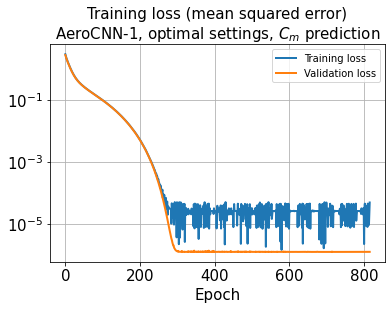

In [29]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-1, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

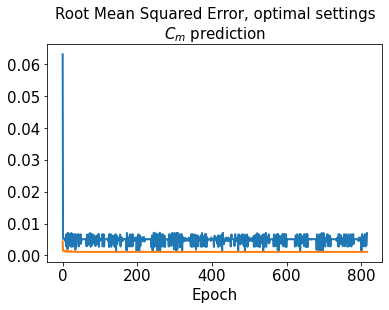

In [30]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

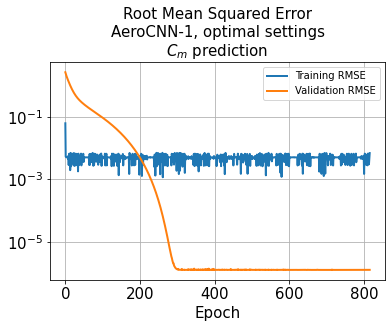

In [31]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-1, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [32]:
train_results = model.evaluate([x_train, x_para_train], y_train)

1750/1750 [==============================] - 5s 3ms/step - loss: 2.5618e-05 - rmse: 0.0051


In [33]:
val_results = model.evaluate([x_val, x_para_val], y_val)

501/501 [==============================] - 2s 4ms/step - loss: 1.2593e-06 - rmse: 0.0011


In [34]:
test_results = model.evaluate([x_test, x_para_test], y_test)

250/250 [==============================] - 1s 4ms/step - loss: 1.0038e-05 - rmse: 0.0032


In [35]:
decoded_train_ = model.predict([x_train, x_para_train])
decoded_val_ = model.predict([x_val, x_para_val])
decoded_test_ = model.predict([x_test, x_para_test])

250/250 [==============================] - 1s 2ms/step


In [36]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [37]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [38]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [39]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [40]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [41]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [42]:
model_directory = "D:\\TrainedModels\\20221218"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221218unsteadyValidation_AeroCNN1_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"unitsCmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [43]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [44]:
os.chdir(storage_dir)

In [45]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [46]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = mape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.98953494025213
668.874295505397


In [47]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= mape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.8454624234201482
526.1688162947289


In [48]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= mape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.9725986136796669
613.0168331074823


In [49]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [50]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [51]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [52]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = mape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [53]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = mape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [54]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = mape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [55]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    plot_title = '$L_2$ error norm distribution - AeroCNN-1, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
         l2_error_train*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

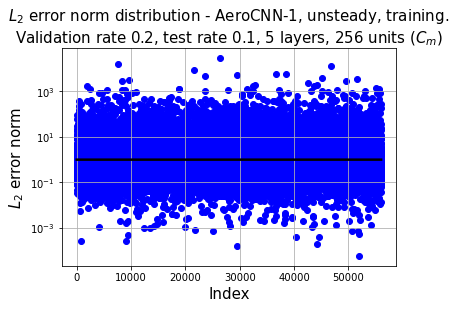

In [56]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

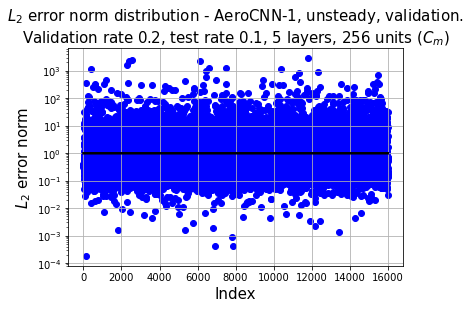

In [57]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

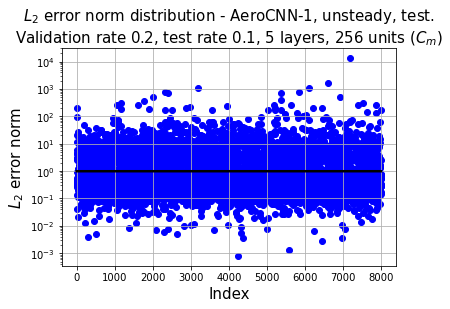

In [58]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [59]:
predicted = model.predict([x, x_para])

2500/2500 [==============================] - 5s 2ms/step


In [60]:
np.max(x)

0.0899969955485105

In [61]:
t_train = t[index_train]
t_val = t[index_val]
t_test = t[index_test]

In [62]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [69]:
x[0,:,:,:]

array([[[ 0.02689964],
        [ 0.04143287],
        [ 0.05175948],
        [ 0.05970001],
        [ 0.06610518],
        [ 0.07134219],
        [ 0.07565321],
        [ 0.07919204],
        [ 0.0820983 ],
        [ 0.084467  ],
        [ 0.08633761],
        [ 0.08777314],
        [ 0.08883208],
        [ 0.08952548],
        [ 0.08990554],
        [ 0.089997  ],
        [ 0.08980556],
        [ 0.08938369],
        [ 0.08872199],
        [ 0.08784509],
        [ 0.08678237],
        [ 0.08553293],
        [ 0.08410421],
        [ 0.08252498],
        [ 0.08080335],
        [ 0.07892746],
        [ 0.07692563],
        [ 0.07480527],
        [ 0.07256919],
        [ 0.07021322],
        [ 0.06775739],
        [ 0.06520957],
        [ 0.06255477],
        [ 0.05981111],
        [ 0.05698391],
        [ 0.0540609 ],
        [ 0.05105962],
        [ 0.04797466],
        [ 0.04480337],
        [ 0.04155417],
        [ 0.03821789],
        [ 0.0348029 ],
        [ 0.03130481],
        [ 0

In [63]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [64]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], Cm, 'k-', label='Ground truth')
    plt.plot(t[:5000], cm, 'k--', label='Predicted value')
    plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, iTest, color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
#     plt.ylim([0, 0.12])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cm: 0.4439


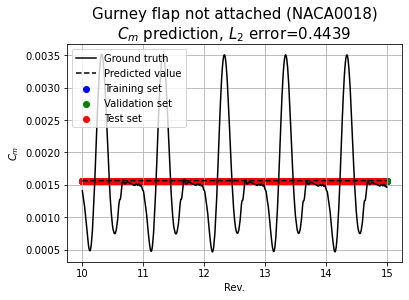

L2 error of Cm: 0.4882


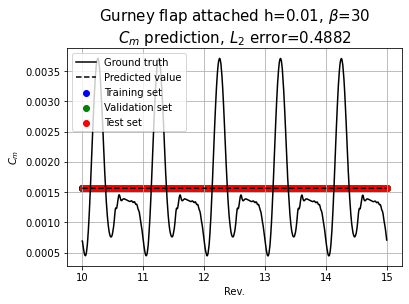

L2 error of Cm: 0.4824


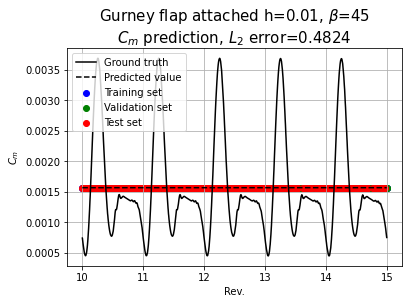

L2 error of Cm: 0.4688


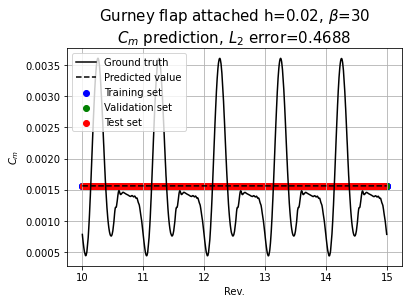

L2 error of Cm: 0.4641


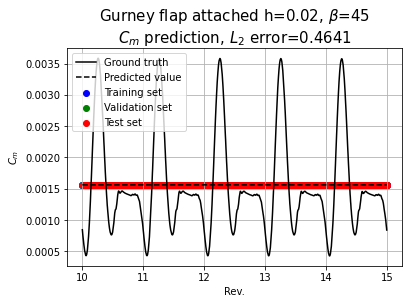

L2 error of Cm: 0.4466


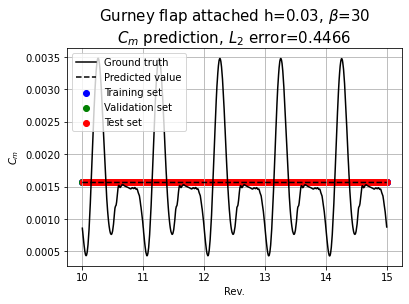

L2 error of Cm: 0.4498


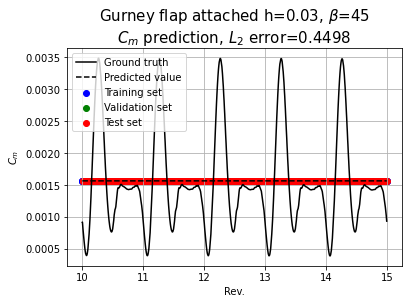

L2 error of Cm: 0.9931


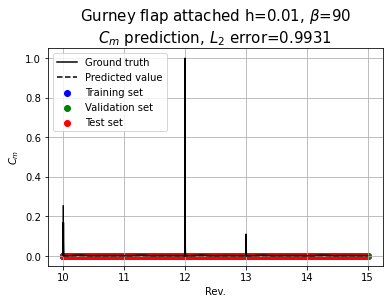

L2 error of Cm: 0.4653


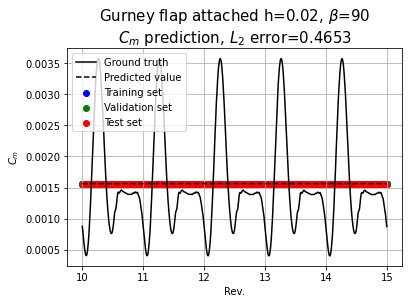

L2 error of Cm: 0.4536


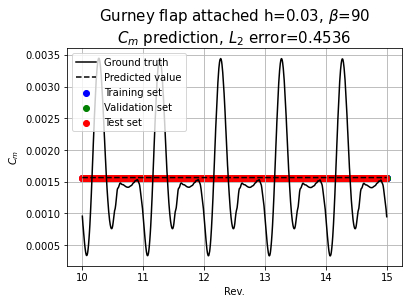

L2 error of Cm: 0.4830


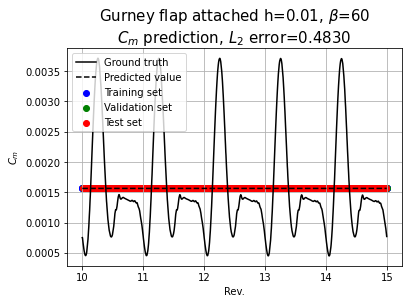

L2 error of Cm: 0.4609


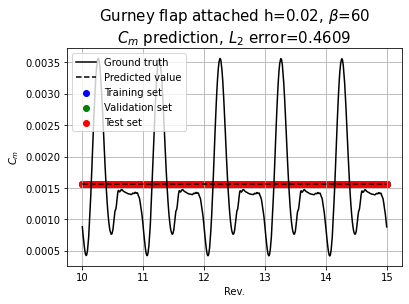

L2 error of Cm: 0.4473


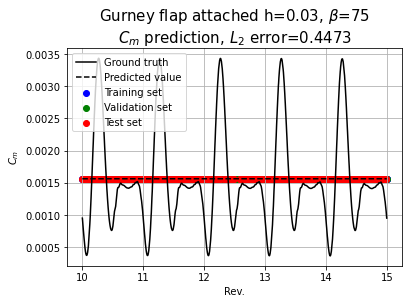

L2 error of Cm: 0.4812


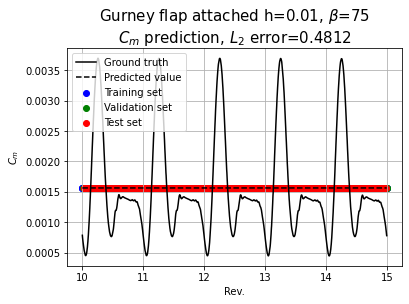

L2 error of Cm: 0.4598


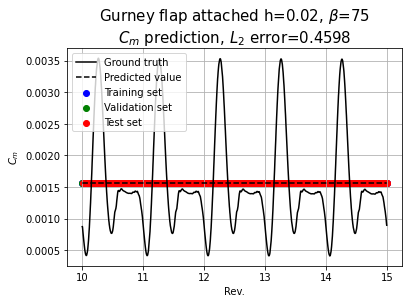

L2 error of Cm: 0.4495


IndexError: list index out of range

In [65]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(0, 16):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain = np.array(iTrain)
    iVal = np.array(iVal)
    iTest = np.array(iTest)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest)